# Setup

In [78]:
import warnings; warnings.simplefilter('ignore')
# set this to your working directory
%matplotlib inline
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
df=df.reset_index(drop=True)
df = df.assign(author_id=(df['authorship']).astype('category').cat.codes)
df = df[pd.notnull(df['authorship'])] # drop cases without an author
import numpy as np
vocab = pd.read_pickle('vocab.pkl')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [79]:
df.head()

case_name opinion_type  \
0                ERICK CORNELL CLAY v. UNITED STATES     majority   
1  HILLSIDE DAIRY INC., A&A DAIRY, L&S DAIRY, AND...     majority   
2    CHARLES RUSSELL RHINES v. DOUGLAS WEBER, WARDEN     majority   
3        STATE OF ALASKA v. UNITED STATES OF AMERICA     majority   
4  REGINALD A. WILKINSON, DIRECTOR, OHIO DEPARTME...     majority   

  date_standard authorship  x_republican  \
0    2003-03-04   GINSBURG           0.0   
1    2003-06-09    STEVENS           1.0   
2    2005-03-30   O'CONNOR           1.0   
3    2005-06-06    KENNEDY           1.0   
4    2005-06-13    KENNEDY           1.0   

                                          maj_judges  \
0  ['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...   
1  ['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...   
2  ['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...   
3  ['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...   
4  ['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...   

                                      dissent_judges  topic_id  cite_count  \
0                                                 []       1.0      2926.0   
1                               ['THOMAS, CLARENCE']       8.0       117.0   
2                                                 []       1.0     23364.0   
3  ['REHNQUIST, WILLIAM', 'SCALIA, ANTONIN', 'THO...      10.0        84.0   
4                                                 []       4.0      4230.0   

                                        opinion_text  year  log_cite_count  \
0  JUSTICE GINSBURG delivered the opinion of the ...  2003        7.981392   
1  Justice Stevens delivered the opinion of the C...  2003        4.762174   
2  Justice O'Connor delivered the opinion of the ...  2005       10.058952   
3  Justice Kennedy delivered the opinion of the C...  2005        4.430817   
4  Justice Kennedy delivered the opinion of the C...  2005        8.349957   

   author_id  
0          2  
1          9  
2          4  
3          3  
4          3

# Entity Embeddings

In [80]:
# make judge dummy variables
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
J = encoder.fit_transform(df['author_id'].astype(str))
num_judges = max(J)+1
Y = df['x_republican'] > 0
Y2 = df['log_cite_count']

In [81]:
J[:10]

array([ 3, 10,  5,  4,  4,  9,  1,  3,  2,  3])

In [82]:
# set up DNN
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

model = Sequential()
model.add(Embedding(num_judges, # number of categories
                    2, # dimensions of embedding
                    input_length=1)) 
model.add(Flatten()) # needed after Embedding
model.add(Dense(2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#dot = model_to_dot(model,
#                   show_shapes=True,
#                   show_layer_names=False)
#SVG(dot.create(prog='dot', format='svg'))

In [83]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1, 2)              22        
                                                                 
 flatten_6 (Flatten)         (None, 2)                 0         
                                                                 
 dense_12 (Dense)            (None, 2)                 6         
                                                                 
 dense_13 (Dense)            (None, 1)                 3         
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


 6/20 [========>.....................] - ETA: 0s - loss: 0.6924 - accuracy: 0.5990 

2022-04-01 08:31:01.089707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/20 [>.............................] - ETA: 0s - loss: 0.6727 - accuracy: 0.8750

2022-04-01 08:31:01.442936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 0s 12ms/step - loss: 0.6289 - accuracy: 0.7752 - val_loss: 0.6176 - val_accuracy: 0.7662


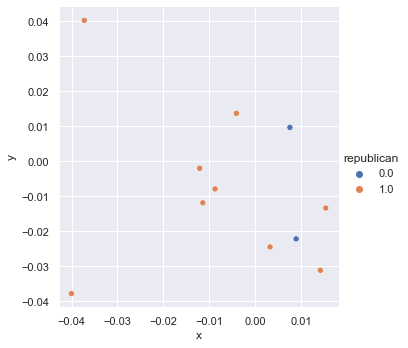

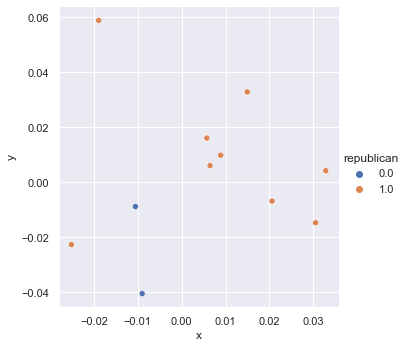

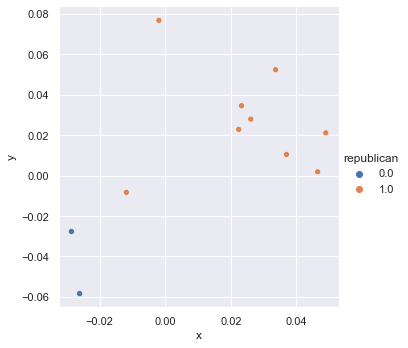

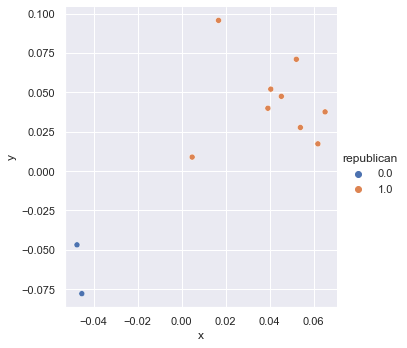

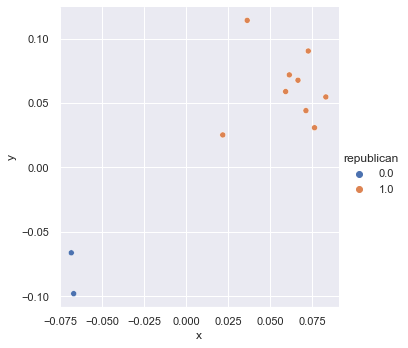

In [84]:
# Visualize the Judge Vectors
#!pip install ggplot
import seaborn as sns
sns.set_theme()

judge_cites = dict(Y.groupby(J).mean())
df2 = pd.DataFrame(J,columns=['authorship']).drop_duplicates().sort_values('authorship')
df2['republican'] = df2['authorship'].apply(lambda x: judge_cites[x])

for i in range(5):
    if i > 0:
        model.fit(J,Y,epochs=1, validation_split=.2)
    
    judge_vectors = model.layers[0].get_weights()[0]
    df2['x'] = judge_vectors[:,0]
    df2['y'] = judge_vectors[:,1]    

    sns.relplot( data=df2, x="x", y="y", hue='republican', kind='scatter')


# Word Embeddings

In [37]:
# convert documents to sequences of word indexes
from keras.preprocessing.text import Tokenizer
num_words = 200
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df['opinion_text'])
sequences = tokenizer.texts_to_sequences(df['opinion_text'])
len(sequences)

768

In [38]:
sequences[0]

[138,
 1,
 111,
 2,
 1,
 19,
 4,
 22,
 4,
 48,
 10,
 195,
 40,
 14,
 8,
 46,
 21,
 11,
 185,
 3,
 4,
 76,
 108,
 5,
 34,
 1,
 24,
 37,
 1,
 100,
 2,
 21,
 49,
 29,
 50,
 1,
 10,
 1,
 76,
 20,
 4,
 47,
 109,
 24,
 37,
 94,
 2,
 82,
 35,
 72,
 4,
 159,
 6,
 4,
 48,
 27,
 34,
 4,
 100,
 2,
 47,
 69,
 12,
 10,
 4,
 2,
 34,
 29,
 19,
 69,
 1,
 100,
 10,
 195,
 49,
 72,
 1,
 19,
 38,
 1,
 18,
 64,
 24,
 1,
 72,
 1,
 108,
 10,
 4,
 10,
 6,
 31,
 29,
 149,
 2,
 6,
 1,
 2,
 140,
 7,
 1,
 2,
 19,
 158,
 28,
 1,
 2,
 1,
 19,
 16,
 1,
 10,
 1,
 2,
 1,
 24,
 21,
 76,
 28,
 4,
 100,
 2,
 72,
 1,
 108,
 10,
 4,
 10,
 1,
 149,
 2,
 1,
 99,
 6,
 135,
 32,
 2,
 7,
 2,
 6,
 1,
 53,
 41,
 62,
 19,
 10,
 1,
 62,
 2,
 24,
 1,
 19,
 2,
 82,
 10,
 1,
 170,
 54,
 5,
 149,
 24,
 30,
 117,
 4,
 49,
 7,
 66,
 72,
 42,
 10,
 11,
 4,
 19,
 2,
 120,
 2,
 100,
 91,
 12,
 4,
 10,
 4,
 2,
 1,
 108,
 6,
 37,
 59,
 104,
 35,
 10,
 24,
 120,
 2,
 1,
 19,
 2,
 100,
 30,
 29,
 149,
 73,
 49,
 7,
 120,
 1,
 2,
 1,
 149,
 24,

In [39]:
# represent data as numrows x maxlen matrix
from keras.preprocessing.sequence import pad_sequences
maxlen = max([len(sent) for sent in sequences]) 
maxlen

13971

In [40]:
X = pad_sequences(sequences, maxlen=maxlen)
X.shape

(768, 13971)

In [41]:
X[0]

array([ 0,  0,  0, ..., 20, 11, 81], dtype=int32)

In [42]:
X[0][maxlen-len(sequences[0]):]

array([138,   1, 111, ...,  20,  11,  81], dtype=int32)

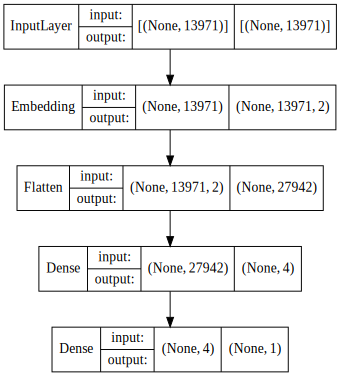

In [43]:
# Model setup
model = Sequential()
model.add(Embedding(num_words,
                    2,
                    input_length=maxlen)) # sequence length
model.add(Flatten()) # 86*2 = 172 dims
model.add(Dense(4))
model.add(Dense(1))
model.compile(optimizer='adam',loss='binary_crossentropy')
from IPython.display import HTML
style = "<style>svg{width:50% !important;height:50% !important;}</style>"
HTML(style)
dot = model_to_dot(model, show_shapes=True, show_layer_names=False,  dpi=70)
SVG(dot.create(prog='dot', format='svg'))

In [44]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 13971, 2)          400       
                                                                 
 flatten_4 (Flatten)         (None, 27942)             0         
                                                                 
 dense_8 (Dense)             (None, 4)                 111772    
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 112,177
Trainable params: 112,177
Non-trainable params: 0
_________________________________________________________________


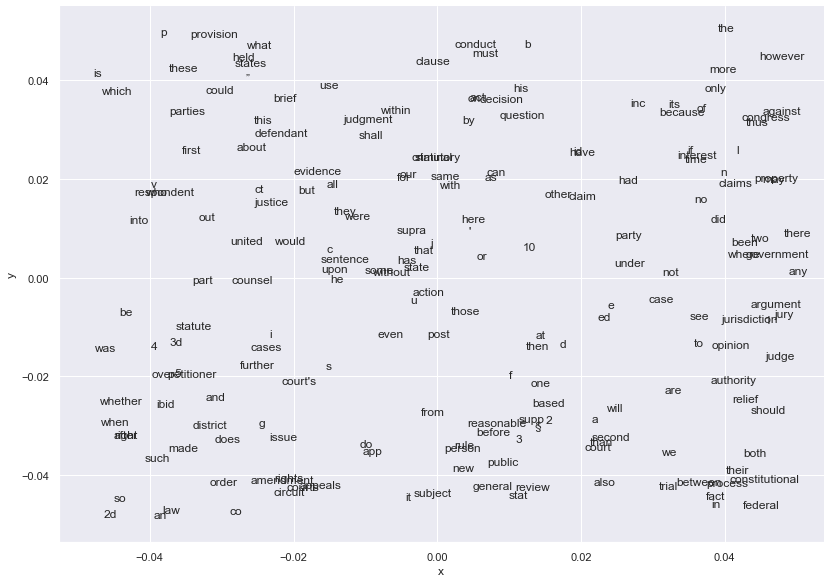

2022-03-31 20:54:19.612247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 20ms/step - loss: 3.8841 - val_loss: 3.5648


2022-03-31 20:54:20.256322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


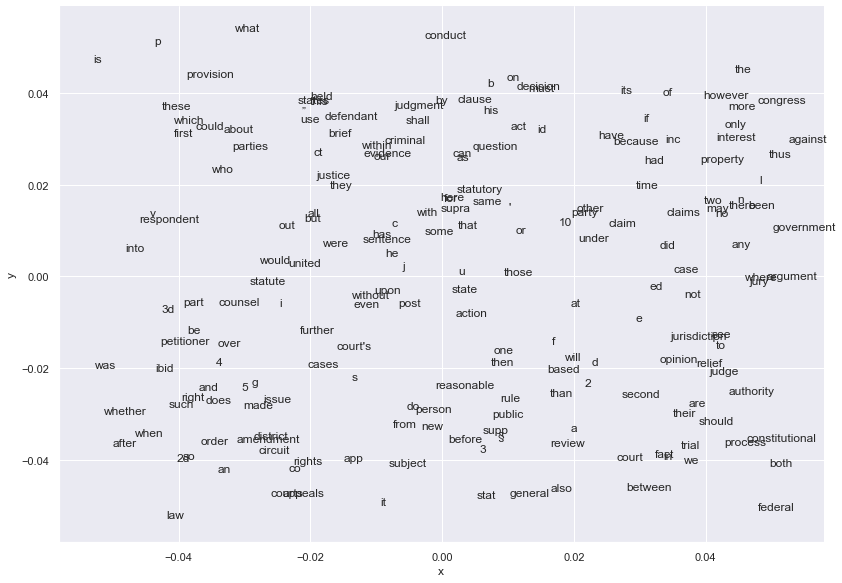

20/20 [==============================] - 0s 15ms/step - loss: 3.4274 - val_loss: 3.5648


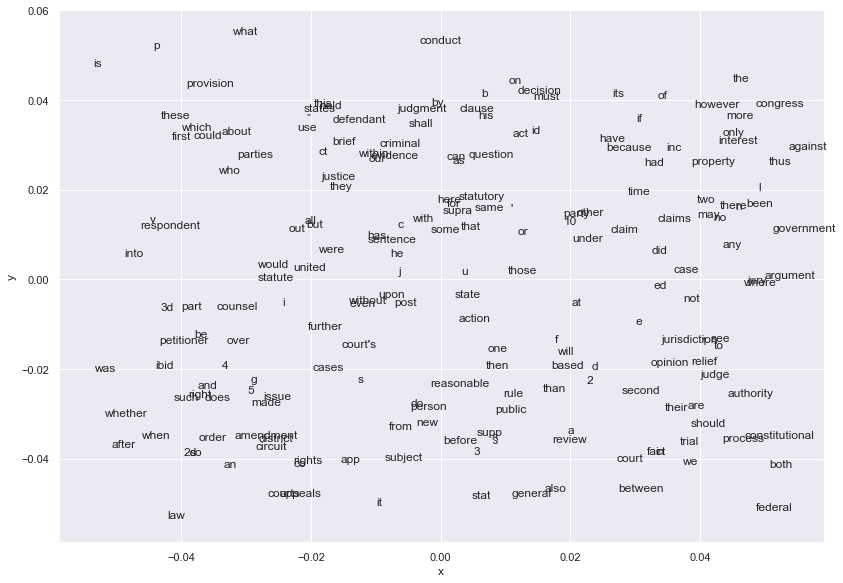

20/20 [==============================] - 0s 15ms/step - loss: 3.4274 - val_loss: 3.5648


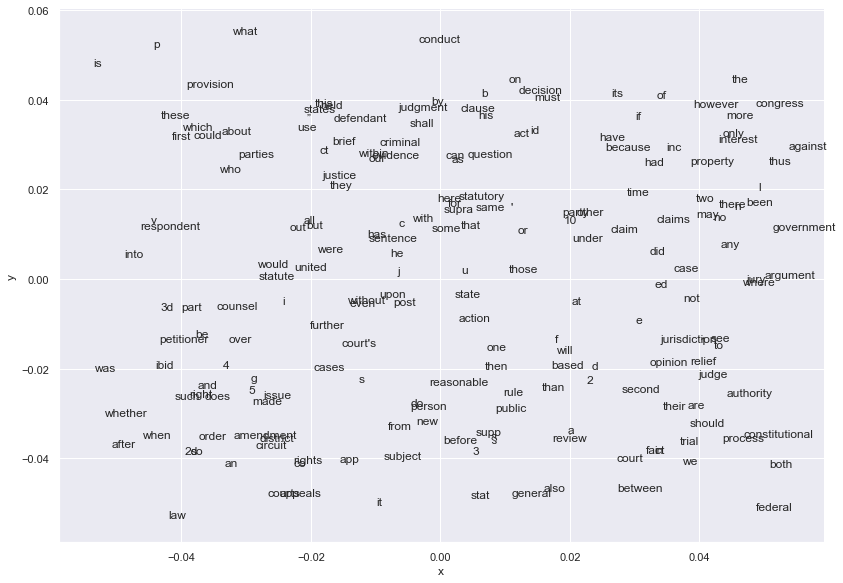

20/20 [==============================] - 0s 14ms/step - loss: 3.4274 - val_loss: 3.5648


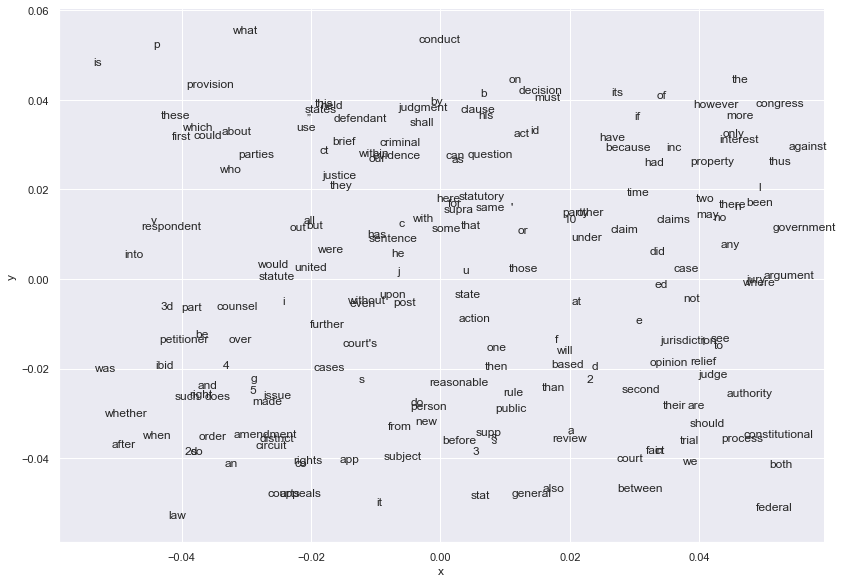

20/20 [==============================] - 0s 15ms/step - loss: 3.4274 - val_loss: 3.5648


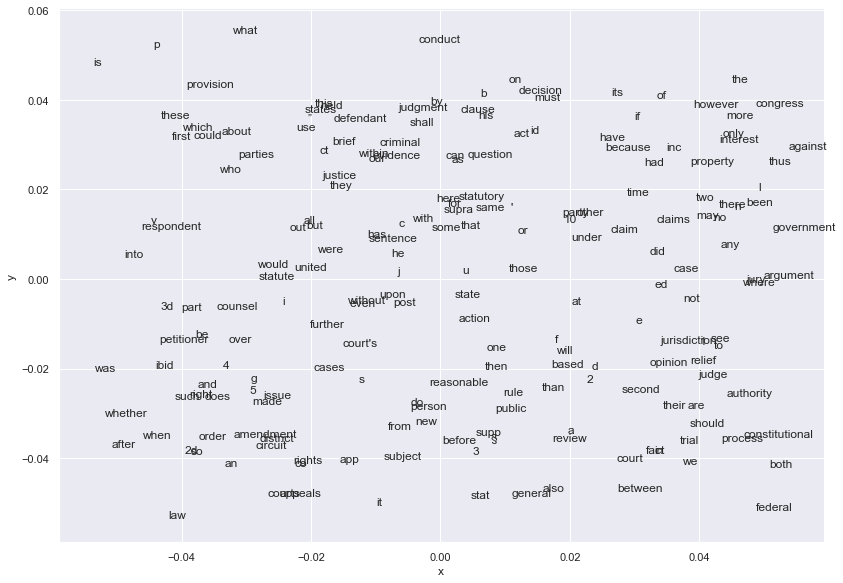

20/20 [==============================] - 0s 14ms/step - loss: 3.4274 - val_loss: 3.5648


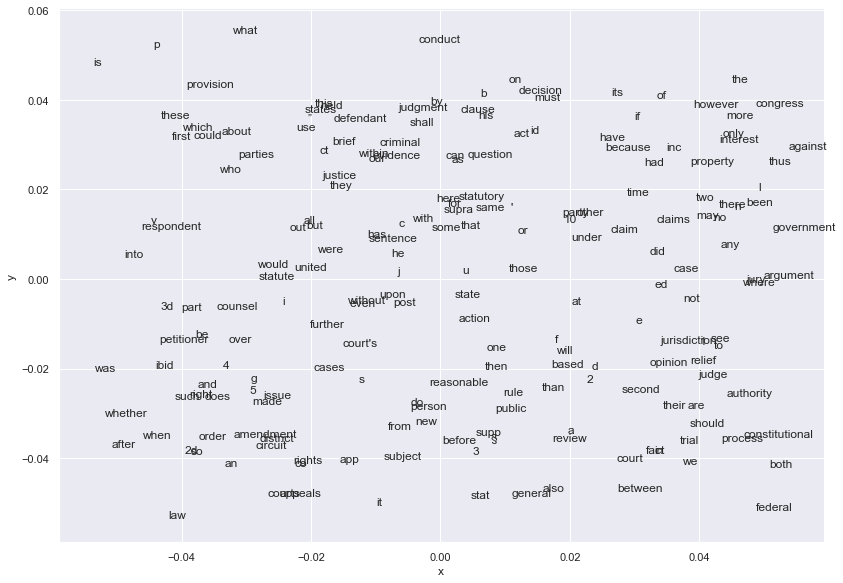

20/20 [==============================] - 0s 15ms/step - loss: 3.4274 - val_loss: 3.5648


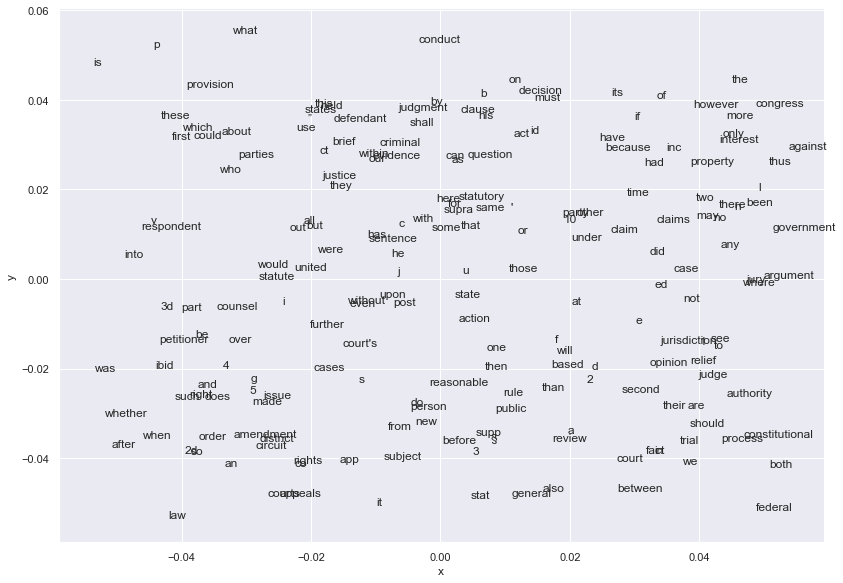

20/20 [==============================] - 0s 14ms/step - loss: 3.4274 - val_loss: 3.5648


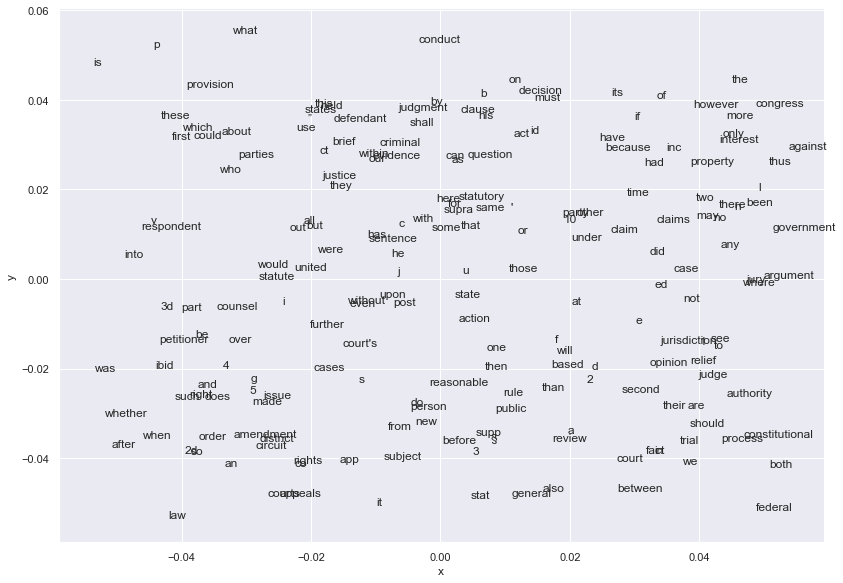

20/20 [==============================] - 0s 14ms/step - loss: 3.4274 - val_loss: 3.5648


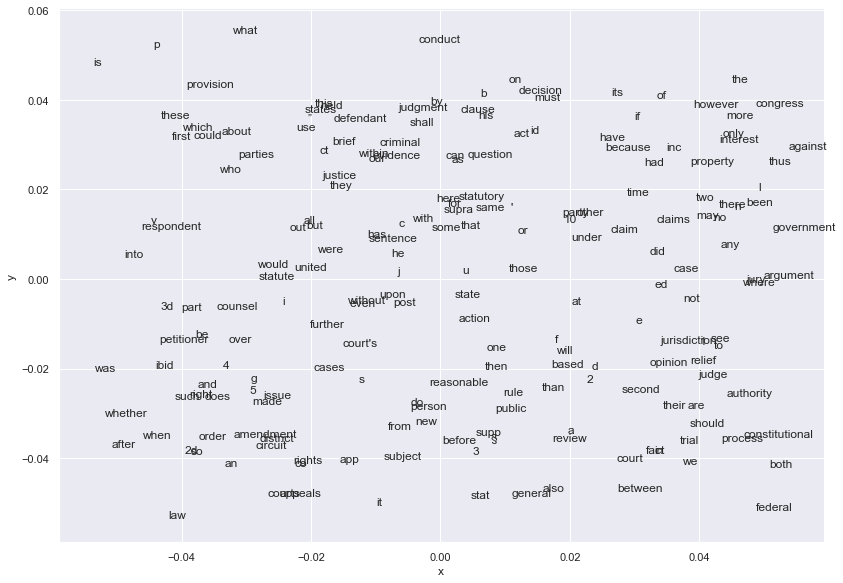

In [45]:
# show the vectors
from matplotlib import pyplot as plt

df3 = pd.DataFrame(list(tokenizer.word_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(10):
    if i > 0:
        model.fit(X,Y,epochs=1, validation_split=.2)

    word_vectors = model.layers[0].get_weights()[0]
    df3['x'] = word_vectors[:,0]
    df3['y'] = word_vectors[:,1]

    plot = sns.relplot( data=df3, x="x", y="y", s=0, height=8.27, aspect=11.7/8.27)

    for row in df3.itertuples():
        ax = plot.axes[0, 0]
        ax.text(row.x, row.y, row.word, horizontalalignment='left')
    plt.show()


In [46]:
# Word Similarity
from scipy.spatial.distance import cosine

vec_defendants = word_vectors[tokenizer.word_index['defendant']-1]
vec_sent = word_vectors[tokenizer.word_index['sentence']-1]
vec_against = word_vectors[tokenizer.word_index['against']-1]

print(1-cosine(vec_defendants, vec_sent))

0.8865906000137329


In [47]:
print(1-cosine(vec_defendants, vec_against))

0.054540831595659256


# Word2Vec in gensim

In [48]:
# word2vec requires sentences as input
from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v.save('w2v-vectors.pkl')

w2v.wv['judg'] # vector for "judge"

array([ 4.30423133e-02,  4.46700398e-03, -2.55543850e-02,  6.84492569e-03,
       -5.03079314e-03, -5.48538705e-03,  1.84638724e-02, -2.88482243e-03,
        4.82392311e-02, -8.19390267e-02,  4.96076187e-03, -1.16124533e-01,
       -4.27243160e-03, -9.82623361e-03, -4.85900007e-02, -6.08660839e-02,
        5.06253801e-02,  5.26559763e-02,  2.77667698e-02, -2.87617575e-02,
        7.38729164e-02,  5.43789640e-02, -2.45802142e-02, -2.92748809e-02,
        9.50461328e-02,  3.35870385e-02,  1.23821236e-02, -4.47765812e-02,
       -2.40612961e-02,  1.07894905e-01, -2.19121724e-02,  2.42078286e-02,
        2.21403800e-02,  3.94294038e-02,  6.25571087e-02, -7.16266483e-02,
       -2.65380610e-02, -1.08811878e-01,  8.62921309e-03,  6.22275434e-02,
       -6.09913282e-02,  4.69075665e-02, -2.60055866e-02,  9.23887640e-03,
       -6.65703565e-02, -3.52290720e-02, -4.74731717e-03,  2.22736737e-03,
        6.63517509e-03, -4.28775176e-02, -5.19480221e-02,  2.89005674e-02,
       -5.45587875e-02,  

In [49]:
w2v.wv.similarity('judg','juri') # similarity 

0.57158613

In [50]:
w2v.wv.most_similar('judg') # most similar words

[('bench', 0.5953693389892578),
 ('juri', 0.5715861320495605),
 ('magistr', 0.5351980328559875),
 ('panel', 0.5351102352142334),
 ('court', 0.533636212348938),
 ('factfind', 0.5213727355003357),
 ('speedi', 0.5193161964416504),
 ('imparti', 0.5167227387428284),
 ('special', 0.4996529221534729),
 ('prosecutor', 0.49743568897247314)]

In [51]:
# word2vec requires sentences as input
from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower#.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words ]#if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v.save('w2v-vectors.pkl')

w2v.wv['judg'] # vector for "judge"

array([ 0.02851629, -0.07923002, -0.00551179,  0.0383895 , -0.07205567,
       -0.01206726,  0.04564866, -0.00605167, -0.01043567, -0.01504642,
       -0.00983567, -0.04574488,  0.04552822, -0.15329002, -0.02193193,
       -0.12876393,  0.15120699, -0.06422534, -0.05565018, -0.03013898,
        0.09613314,  0.00678954,  0.02318116,  0.07089709, -0.04036016,
        0.07273384,  0.08443981,  0.02420141,  0.0626275 ,  0.03980436,
        0.0383553 ,  0.02891082,  0.01637372,  0.08545417, -0.05382832,
       -0.08237512,  0.00599404,  0.02509696,  0.00212319,  0.07038054,
       -0.02002814, -0.01676246, -0.02776926, -0.09583973,  0.06601088,
       -0.04045736, -0.05706986,  0.0018374 ,  0.06114435, -0.08134822,
       -0.05433097,  0.03152781, -0.15251632,  0.03546267, -0.00323954,
        0.00208544, -0.07791933,  0.00187374, -0.05247102,  0.03435352,
       -0.04539087,  0.06423523, -0.04655546, -0.00838754,  0.01257413,
       -0.01209248,  0.00452459, -0.06278877,  0.04203266, -0.07

In [52]:
w2v.wv.similarity('judg','juri') # similarity 

0.66678697

In [53]:
w2v.wv.most_similar('judg') # most similar words

[('judge,', 0.8131026029586792),
 ('juri', 0.6667869687080383),
 ('jury,', 0.6435332298278809),
 ('prosecutor', 0.5896973609924316),
 ('court', 0.5746570825576782),
 ('magistr', 0.574337363243103),
 ('judge.', 0.5527392625808716),
 ('court,', 0.5474913120269775),
 ('juror', 0.5471761226654053),
 ('unanim', 0.5340203046798706)]

In [61]:
# analogies: judge is to man as __ is to woman
w2v.wv.most_similar(positive=['judg','man'],
                 negative=['woman'])

[('judge,', 0.7236223220825195),
 ('jury,', 0.54631507396698),
 ('magistr', 0.5323208570480347),
 ('juri', 0.5232703685760498),
 ('court', 0.49149343371391296),
 ('court,', 0.4844695031642914),
 ('judges,', 0.4844566583633423),
 ('prosecutor', 0.48023268580436707),
 ('unanim', 0.47240495681762695),
 ('juror', 0.467909574508667)]

In [55]:
# Word2Vec: K-Means Clusters
from sklearn.cluster import KMeans
kmw = KMeans(n_clusters=50)
kmw.fit(w2v.wv.vectors)
judge_clust = kmw.labels_[w2v.wv.vocab['judg'].index]
for i, cluster in enumerate(kmw.labels_):
    if cluster == judge_clust and i<=100:
        print(w2v.wv.index2word[i])

his
he
defend


# Pre-trained vectors

In [56]:
import spacy
en = spacy.load('en_core_web_sm')
apple = en('apple') 
apple.vector # vector for 'apple'

array([-1.1682467 , -0.37714788,  0.12145048,  0.45870164,  0.18772918,
       -0.1963262 , -0.6110374 , -0.49027702, -0.4964213 ,  0.03152998,
        0.00236143,  0.295166  ,  0.7754728 ,  1.2774849 , -0.43516952,
        0.6209066 ,  0.5234564 , -0.65061843,  0.09567976, -0.10973877,
       -1.0401254 , -0.03391558,  0.7943468 ,  0.57635796, -0.33247292,
        0.62733513, -0.5002358 , -1.2046778 ,  0.08557361, -0.72076726,
        0.9980813 , -1.4318948 , -0.24133739, -0.9739392 ,  0.2621435 ,
       -1.7072632 , -0.44079256, -0.07828841, -0.8650366 ,  0.90954286,
       -0.5113236 , -1.088126  , -0.07267341,  0.37482584, -0.7151478 ,
       -0.7081645 ,  0.22494677, -0.09205629,  2.038835  ,  1.6421664 ,
        0.13038194,  0.874071  , -0.38315964, -0.55294967, -0.43678957,
        0.5167304 , -0.9234771 , -0.00989905,  0.7303826 , -0.57531387,
       -0.7816253 , -0.0768221 ,  0.28484577, -0.49553034,  0.21016783,
       -0.05586189, -0.97006464,  0.05051011, -0.15979545, -0.17

In [57]:
apple.similarity(apple)

1.0

In [58]:
orange = en('orange')
apple.similarity(orange)

0.6120259962521467

In [63]:
import spacy
# !python -m spacy download de_core_news_sm
de = spacy.load('de_core_news_sm')
apfel = de('apfel')
orange = de('orange')
apfel.similarity(orange)

0.5679783767388717

In [64]:
# Initializing an embedding layer with pre-trained vectors
embed_dims = len(apple.vector)
embedding_matrix = np.zeros([num_words, embed_dims])
for word, i in tokenizer.word_index.items():
    if i > num_words:
        break
    embedding_vector = en(word).vector
    embedding_matrix[i-1] = embedding_vector    

In [65]:
model = Sequential()
model.add(Embedding(num_words,
                    embed_dims,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False)) # frozen layer
model.add(Flatten()) # 86*300 = 25800 dims
model.add(Dense(64,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 13971, 96)         19200     
                                                                 
 flatten_5 (Flatten)         (None, 1341216)           0         
                                                                 
 dense_10 (Dense)            (None, 64)                85837888  
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 85,857,153
Trainable params: 85,837,953
Non-trainable params: 19,200
_________________________________________________________________


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 3.726499
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.360161
[t-SNE] KL divergence after 300 iterations: 0.608156


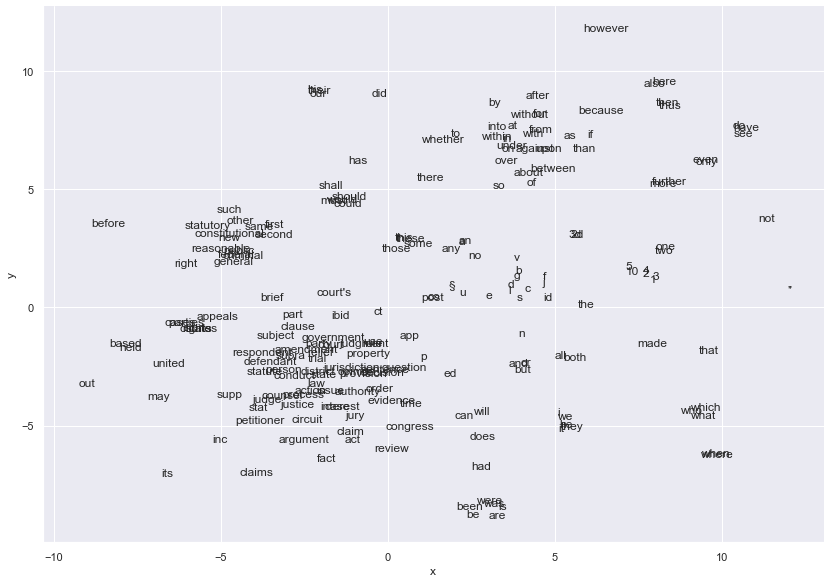

2022-04-01 00:16:06.749742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 3.2868 - accuracy: 0.7655

2022-04-01 00:16:43.826804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 46s 2s/step - loss: 3.2868 - accuracy: 0.7655 - val_loss: 3.5648 - val_accuracy: 0.7662
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 3.726499
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.528172
[t-SNE] KL divergence after 300 iterations: 0.555090


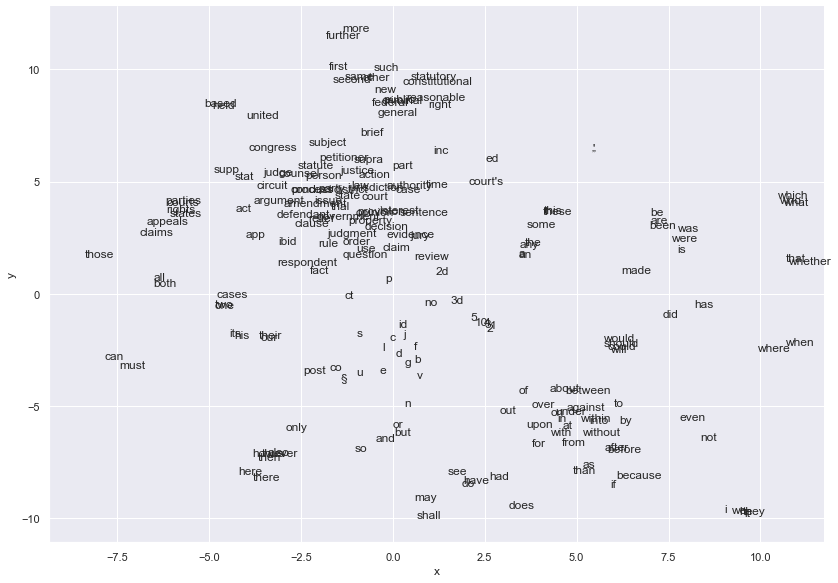

20/20 [==============================] - 45s 2s/step - loss: 3.4274 - accuracy: 0.7752 - val_loss: 3.5648 - val_accuracy: 0.7662
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 3.726499
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.515503
[t-SNE] KL divergence after 300 iterations: 0.464921


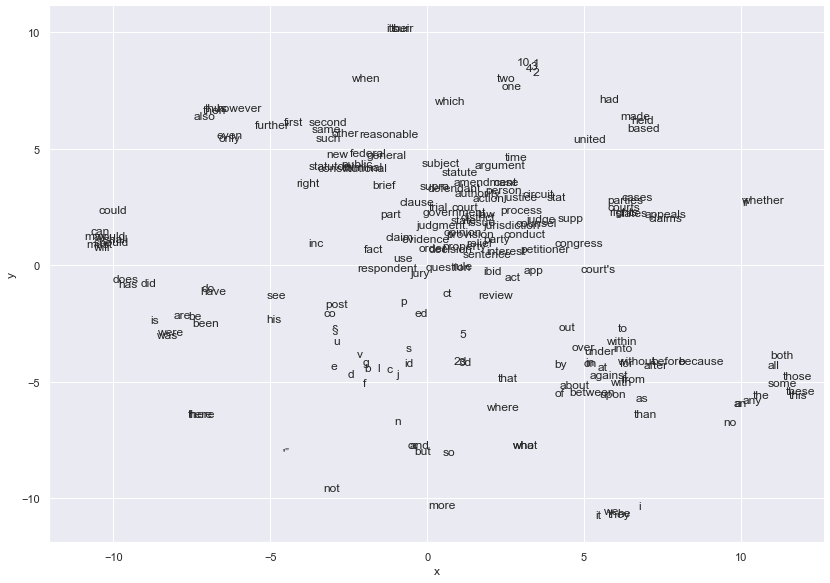

In [67]:
# show the vectors
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)

df3 = pd.DataFrame(list(tokenizer.word_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(3):
    if i > 0:
        model.fit(X,Y,epochs=1, validation_split=.2)
    
    word_vectors = model.layers[0].get_weights()[0]
    wv_tsne = tsne.fit_transform(word_vectors)

    df3['x'] = wv_tsne[:,0]
    df3['y'] = wv_tsne[:,1]
    plot = sns.relplot( data=df3, x="x", y="y", s=0, height=8.27, aspect=11.7/8.27)

    for row in df3.itertuples():
        ax = plot.axes[0, 0]
        ax.text(row.x, row.y, row.word, horizontalalignment='left')
    plt.show()

# GloVe

In [ ]:
!pip install glove-python-binary 
#!pip install glove_python for other versions

import itertools
from glove import Corpus, Glove

from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

corpus = Corpus()
corpus.fit(sentences, window=10)
glove = Glove(no_components=100, learning_rate=0.05)

In [ ]:
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

In [ ]:
glove.word_vectors[glove.dictionary['judg']]

In [ ]:
glove.most_similar('judg')


# Word Mover Distance

In [87]:
!pip install wmd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [7 lines of output]
      running bdist_wheel
      running build
      running build_py
      running build_ext
      building 'libwmdrelax' extension
      clang: error: the clang compiler does not support '-march=native'
      error: command '/usr/bin/gcc' failed with exit code 1
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for wmd
  Running setup.py clean for wmd
Failed to build wmd
  Running setup.py install for wmd ... error
  error: subprocess-exited-with-error
  
  × Running setup.py install for wmd did not run successfully.
  │ exit code: 1
  ╰─> [9 lines of output]
      running install
      /Users/afra/University/NLP-LSS/.venv/lib/python3

In [86]:
import spacy
import wmd
nlp = spacy.load('en_core_web_sm', 
                 create_pipeline=wmd.WMD.create_spacy_pipeline)
doc1 = nlp("Politician speaks to the media in Illinois.")
doc2 = nlp("The president greets the press in Chicago.")
print(doc1.similarity(doc2))

ModuleNotFoundError: No module named 'wmd'

# Embedding Lookup

Keras provides functionality to feed just words (actually indices of words) as model input. The model then performs an embedding lookup (we go from sparse one-hot to dense) which then becomes the input for further computation in the model. For a more detailed tutorial, have a look [here](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/). 

First, we have to pre-process the data once again

In [70]:
#df['opinion_text']

from keras.preprocessing.text import text_to_word_sequence

# tokenize the text


tokenized = [text_to_word_sequence(opinion) for opinion in df["opinion_text"]]
print (tokenized[0][:50])

['justice', 'ginsburg', 'delivered', 'the', 'opinion', 'of', 'the', 'court', 'a', 'motion', 'by', 'a', 'federal', 'prisoner', 'for', 'postconviction', 'relief', 'under', '28', 'u', 's', 'c', '§', '2255', 'is', 'subject', 'to', 'a', 'one', 'year', 'time', 'limitation', 'that', 'generally', 'runs', 'from', 'the', 'date', 'on', 'which', 'the', 'judgment', 'of', 'conviction', 'becomes', 'final', '§', '2255', 'p6', '1']


In [71]:
from collections import Counter
counter = Counter()
for i in tokenized:
        counter.update(i)
print (counter.most_common(10))
num_words = len(counter)
print (num_words) ## 58'787
print (max(len(i) for i in tokenized)) # 26'097, this is one of the challenges of working with legal text

[('the', 268092), ('of', 135373), ('to', 107507), ('a', 87432), ('that', 75017), ('in', 72525), ('and', 65488), ('s', 50775), ('at', 40610), ('for', 37386)]
58787
26097


In [72]:
# create one_hot representation for each word
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
length_vocab = 10000
X_one_hot = [one_hot(opinion, n=length_vocab) for opinion in df["opinion_text"]]
print (X_one_hot[0][:50])

[4006, 4868, 9067, 6511, 8250, 6332, 6511, 7077, 5553, 4163, 7308, 5553, 5762, 7947, 9452, 2576, 1779, 210, 4356, 6821, 9858, 7034, 6034, 417, 6394, 7624, 5262, 5553, 1779, 3298, 4258, 6802, 7359, 5751, 9277, 8680, 6511, 2536, 5544, 8341, 6511, 2505, 6332, 8250, 6321, 8728, 6034, 417, 7236, 545]


In [73]:
# next, we pad (or truncate) such that all the inputs have same length

max_seq_length = 2000
X_one_hot_padded = pad_sequences(X_one_hot, padding='post', maxlen=max_seq_length, truncating='post')
X_one_hot_padded.shape # (768, 2000)

(768, 2000)

**Embedding lookup**

In [74]:
from keras.layers import Embedding
from keras.models import Sequential

model = Sequential() # create a sequential model
model.add(Embedding(length_vocab, 64, input_length=max_seq_length, name="embedding_layer"))
model.summary() #640'000 params because 64 dim for 10'000 words

# that's it


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 2000, 64)         640000    
                                                                 
Total params: 640,000
Trainable params: 640,000
Non-trainable params: 0
_________________________________________________________________
